<a target="_blank" href="https://colab.research.google.com/github/lm2612/Tutorials/blob/main/3_deeplearning/3-DeepLearning_HousePrice.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep learning: House price prediction

On Tuesday, we used linear regression to predict house prices of the [California house price dataset](https://www.kaggle.com/camnugent/california-housing-prices). Our dataset contains 200 observations for housing blocks in California obtained from the 1990 census. The dataset contains columns:

1. `longitude`: A measure of how far west a house is; a higher value is farther west

2. `latitude`: A measure of how far north a house is; a higher value is farther north

3. `housing_median_age`: Median age of a house within a block; a lower number is a newer building

4. `total_rooms`: Total number of rooms within a block

5. `total_bedrooms`: Total number of bedrooms within a block

6. `population`: Total number of people residing within a block

7. `households`: Total number of households, a group of people residing within a home unit, for a block

8. `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. `median_house_value`: Median house value for households within a block (measured in US Dollars)

10. `ocean_proximity`: Location of the house w.r.t ocean/sea

Previously, we used intuition to guess what input variables would be suitable predictors. In this example, we are going to  use all the variables available and to predict `median_house_value`.

You must be on google colab for this tutorial - otherwise you will not be able to open the dataset. First, import the needed modules, we will be using `torch` for building neural networks. On Tuesday we used a smaller subset of the full dataset. Load the file `sample_data/california_housing_train.csv`.

In [9]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

df = pd.read_csv("sample_data/california_housing_train.csv")
print(len(df))
df.head()

17000


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [3]:
df.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


Notice the dataset is much larger than Tuesday! Clean up the data and split it into training and validation. Note, we don't need to set aside test data as we will use the test data in `sample_data/california_housing_test.csv`. Remember the data is ordered, you may want to shuffle it.

In [19]:
# Remove nans
df = df.dropna()
print(df.info())

# Shuffle the data
from sklearn.utils import shuffle
df_shuffled = shuffle(df)
print(df_shuffled.info())
df_shuffled.head()




<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 16655 to 6573
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 1095 to 15016
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   hou

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
1095,-117.11,32.70,37.0,2045.0,502.0,1920.0,472.0,1.8125,83300.0
5498,-118.16,33.78,29.0,3684.0,1301.0,3891.0,1143.0,1.6955,179700.0
9064,-118.98,35.36,29.0,1244.0,266.0,933.0,227.0,1.6981,49400.0
5420,-118.16,34.70,33.0,2918.0,494.0,1365.0,478.0,4.8787,127700.0
5863,-118.20,33.96,41.0,1512.0,400.0,1690.0,367.0,3.0550,167000.0


In [25]:
# Use 80% training, 20% validation
# There are 17000 entries --> 80% of 17000 = 13600

training = df.iloc[0:13600,:]
validation = df.iloc[13600:17000,:]

print(training.info)
print(validation.info)


"""
Alternative method to partition data into training and validation datasets
N_train = int(len(df)*0.8)
training = df.iloc[:N_train, :]
validation = df.iloc[N_train:, :]

print(training.info)
print(validation)

"""



<bound method DataFrame.info of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
16655    -122.75     38.46                13.0       4323.0          1020.0   
4816     -118.09     33.95                36.0       1991.0           396.0   
10816    -120.74     39.90                23.0       1017.0           218.0   
5211     -118.13     33.79                44.0       2153.0           375.0   
8779     -118.61     34.16                29.0       4364.0           647.0   
...          ...       ...                 ...          ...             ...   
385      -116.93     32.81                18.0       2447.0           466.0   
10684    -120.59     38.76                21.0       1728.0           417.0   
8446     -118.48     34.23                29.0       3354.0           707.0   
16827    -123.23     39.77                25.0       2075.0           435.0   
2688     -117.68     34.04                27.0        574.0           103.0   

       population  

Get your X and y variables. We will use all of the predictors for X and scale them to zero mean unit variance.

In [26]:
y = training["median_house_value"].values.reshape(-1, 1)
X = training[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']].values
X.shape, y.shape

((13600, 8), (13600, 1))

In [37]:
from sklearn.preprocessing import StandardScaler

# Use StandardScaler to fit and transform your variables
scaler_X = StandardScaler()
scaler_X.fit(X)
X_scaled = scaler_X.transform(X)

scaler_y = StandardScaler()
scaler_y.fit(y)
y_scaled = scaler_y.transform(y)

print(X_scaled.shape)
print(y_scaled.shape)

(13600, 8)
(13600, 1)


Create torch tensors ready for the neural network.

In [43]:
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)

print(X, X.shape)
print(y, y.shape)

tensor([[-1.5918,  1.3271, -1.2448,  ...,  1.0316,  0.5875, -0.4552],
        [ 0.7354, -0.7844,  0.5841,  ..., -0.1089, -0.2572,  0.3266],
        [-0.5880,  2.0012, -0.4496,  ..., -0.9407, -0.9096, -0.8495],
        ...,
        [ 0.5406, -0.6533,  0.0275,  ...,  0.2948,  0.3848,  0.3521],
        [-1.8315,  1.9404, -0.2906,  ..., -0.3940, -0.3248, -1.3957],
        [ 0.9401, -0.7422, -0.1316,  ..., -1.0004, -1.0369,  0.0164]]) torch.Size([13600, 8])
tensor([[-0.5561],
        [-0.3496],
        [-1.0296],
        ...,
        [ 0.2861],
        [-1.2716],
        [-0.1771]]) torch.Size([13600, 1])


## Build a neural network

Create a simple neural network. It can include as many or as few layers as you like. We will start simple with a 3-layer dense neural network, where we have an input layer, and 2 hidden layers with 16 nodes. For the input layer, we need to tell pytorch the number of input features (9). Then we can choose the number of hidden nodes.

In [44]:
class SimpleNet(torch.nn.Module):
    def __init__(self, n_features=8, n_targets=1):
        super().__init__()
        self.n_features = n_features
        self.n_targets = n_targets

        self.layer_input = torch.nn.Linear(self.n_features, 16)         # Input layer: n_features -> 16
        self.layer_hidden1 = torch.nn.Linear(16, 16)                    # Hidden layer 1: 16 -> 16
        self.layer_hidden2 = torch.nn.Linear(16, self.n_targets)        # Hidden layer 2: 16 -> n_targets

        self.activation_function = torch.nn.ReLU()

    def forward(self, X):
        # Input layer
        output = self.layer_input(X)
        output = self.activation_function(output)

        # Hidden layer 1
        output = self.layer_hidden1(output)
        output = self.activation_function(output)

        # Hidden layer 2
        output = self.layer_hidden2(output)
        # Notice we don't use the activation function here - why not? when would we use it?

        return output

## Check our network on one batch
Let's test our neural network on a small batch of data, before we start our training loop. Create an instance of SimpleNet and test it on a batch size of 64.

In [45]:
# Create an instance of SimpleNet
my_network = SimpleNet(n_features=8, n_targets=1)

# Get the first batch
X_batch = X[0:64, :]
y_batch = y[0:64, :]

# Test if we can call my_network without any errors
pred_batch = my_network(X_batch)

# Check the output is the correct size
print(pred_batch.shape)
assert(pred_batch.shape == y_batch.shape)

torch.Size([64, 1])


## Set up loss function and optimisation algorithms

Decide on a suitable loss function.

We will use Mean Squared Error (MSE). It is always good to check you can properly call this on your first batch of data.

In [46]:
loss_function = torch.nn.MSELoss()
loss_function(pred_batch, y_batch)

tensor(1.1411, grad_fn=<MseLossBackward0>)

Set up the optimiser and pass our network parameters to it. We will use the Adam optimiser.

In [47]:
optimiser = torch.optim.Adam(params = my_network.parameters(), lr=0.01)

## Training loop
We are ready to start our training loop. We could manually iterate through the data using indices, e.g., `X[0:64, :], y[0:64, :], ...`. But pytorch simplifies this for us with some useful functions, including mini-batching and shuffling - this will become essential when we move to large datasets. This is done in two steps, both of which are highly customisable.
First, we create a `Dataset` which contains all of our data (you can also include any relevant pre-processing functions inside the Dataset). For regression, we provide our inputs and outputs.
Then, we use a `DataLoader` that allows us to iterate through minibatches of data.

In [49]:
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset,
                                         shuffle=True,
                                         batch_size=64)

In [50]:
# Check we can iterate through the dataloader
X_batch, y_batch = next(iter(dataloader))
X_batch.shape, y_batch.shape

(torch.Size([64, 8]), torch.Size([64, 1]))

In [51]:
losses = []

for X_batch, y_batch in dataloader:
    optimiser.zero_grad()
    pred_batch = my_network(X_batch)
    loss = loss_function(pred_batch, y_batch)
    loss.backward()

    # Update optimiser
    optimiser.step()

    # Add MSE losses to our list for plotting
    losses.append(loss.item())



Plot the losses for this

[1.3901673555374146, 0.8461534380912781, 0.7054843306541443, 0.9047490954399109, 0.6884810328483582, 0.8045347929000854, 0.6049574613571167, 0.7267597913742065, 0.6194549798965454, 0.582035481929779, 0.5408194661140442, 0.927420437335968, 0.7606533765792847, 0.4528859555721283, 0.40831395983695984, 0.6636183857917786, 0.653536856174469, 0.5442763566970825, 0.4648246467113495, 0.4513282775878906, 0.7231160402297974, 0.4259919226169586, 0.4167614281177521, 0.6466582417488098, 0.3173239827156067, 0.3112289011478424, 0.4857271611690521, 0.27336812019348145, 0.47706353664398193, 0.41771259903907776, 0.3962545096874237, 0.21692118048667908, 0.557697594165802, 0.34872695803642273, 0.34304279088974, 0.5449469089508057, 0.726901650428772, 0.4455733001232147, 0.55707186460495, 0.23184509575366974, 0.47369953989982605, 0.38625481724739075, 0.3347781300544739, 0.3038958013057709, 0.33606958389282227, 0.5289247035980225, 0.5113598704338074, 0.33253490924835205, 0.29050663113594055, 0.48758518695831

Text(0.5, 1.0, 'Plotting losses from neural network optimisation')

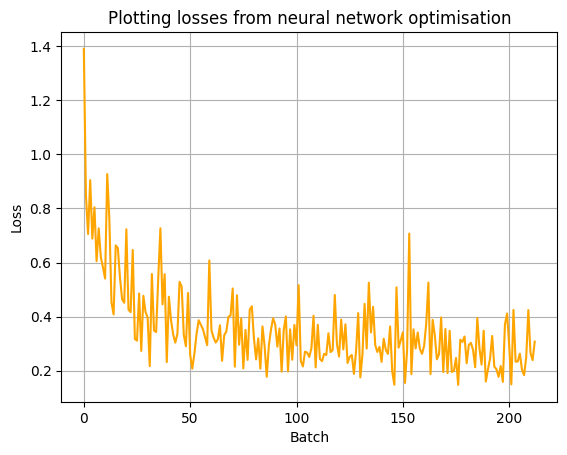

In [61]:
# Plotting losses

print(losses)
plt.plot(losses, color = 'orange', linestyle = '-')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout
plt.title('Plotting losses from neural network optimisation')

## Check validation dataset
Predict using the validation dataset and compare to the true validation dataset. Check our loss function (MSE).


In [59]:
# Select your X_validation and y_validation variables.
y_validation = validation["median_house_value"].values.reshape(-1, 1)
X_validation = validation[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']].values
X_validation.shape, y_validation.shape

# Scale them and create them as torch tensors (as we did for training)

X_validation_scaled = scaler_X.transform(X_validation)
y_validation_scaled = scaler_y.transform(y_validation)

X_validation = torch.tensor(X_validation_scaled, dtype=torch.float32)
y_validation = torch.tensor(y_validation_scaled, dtype=torch.float32)

print(X_validation, X_validation.shape)
print(y_validation, y_validation.shape)

# Create a torch dataset in the same way did before
dataset_validation = torch.utils.data.TensorDataset(X_validation, y_validation)

# And finally, create a validation dataloader with a batch size of 64 in the same way we did before
dataloader_validation = torch.utils.data.DataLoader(dataset_validation,
                                         shuffle=True,
                                         batch_size=64)

tensor([[ 0.7493, -0.8609, -0.2636,  ..., -0.2641, -0.2536,  1.0818],
        [ 0.6897, -0.8095,  1.8748,  ..., -1.0691, -1.2784,  1.7217],
        [ 0.1142,  0.3200, -0.8972,  ..., -0.2626, -0.2328,  0.0812],
        ...,
        [ 0.3077, -0.1094, -0.1052,  ..., -0.1683, -0.1206,  0.8032],
        [-1.5775,  1.3141, -0.8972,  ..., -0.1553, -0.0137, -0.1625],
        [ 0.6352, -0.7255, -0.3428,  ...,  0.9185,  1.7829, -0.7401]]) torch.Size([3400, 8])
tensor([[ 1.2192],
        [ 1.1897],
        [-0.8559],
        ...,
        [-0.5879],
        [-0.3755],
        [ 0.0662]]) torch.Size([3400, 1])


In [62]:
# Test the network on the validation dataset! Note, we need to put the network in "evaluation" mode first
my_network.eval()       # Puts network into evaluation mode
pred_validation = my_network(X_validation)
# Check the loss
loss = loss_function(pred_validation, y_validation)
loss

tensor(0.2807, grad_fn=<MseLossBackward0>)

Plot the predicted against the truth

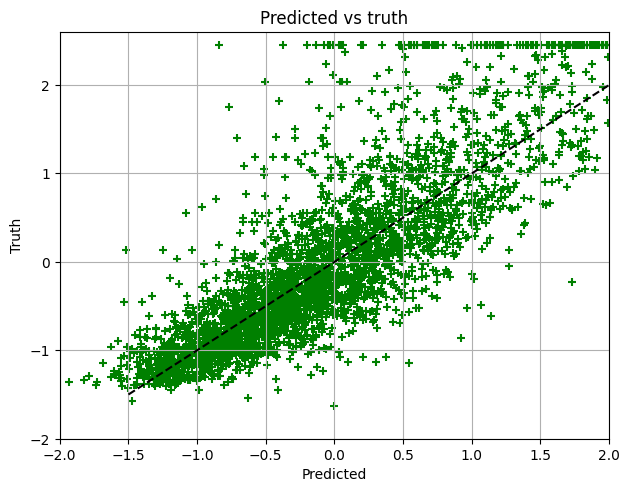

In [83]:
# Plotting predicted against the truth
plt.scatter(pred_validation.detach().numpy(), y_validation.detach().numpy(), color = 'green', marker = '+')
plt.plot([-1.5, 2.5], [-1.5, 2.5], color="black", linestyle="dashed")
plt.ylim(-2,2.6)
plt.xlim(-2,2)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.tight_layout()
plt.title("Predicted vs truth")
plt.grid()

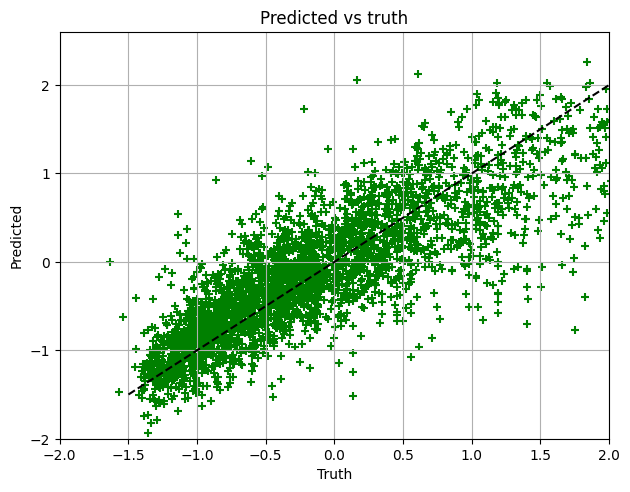

In [95]:
# Plotting predicted on the y xis and truth on the x axis
plt.scatter(y_validation.detach().numpy(), pred_validation.detach().numpy(), color = 'green', marker = '+')
plt.plot([-1.5, 2.5], [-1.5, 2.5], color="black", linestyle="dashed")
plt.ylim(-2,2.6)
plt.xlim(-2,2)
plt.ylabel("Predicted")
plt.xlabel("Truth")
plt.tight_layout()
plt.title("Predicted vs truth")
plt.grid()

How does it compare to your linear regression models on Tuesday?



np.float64(62860.240433548766)

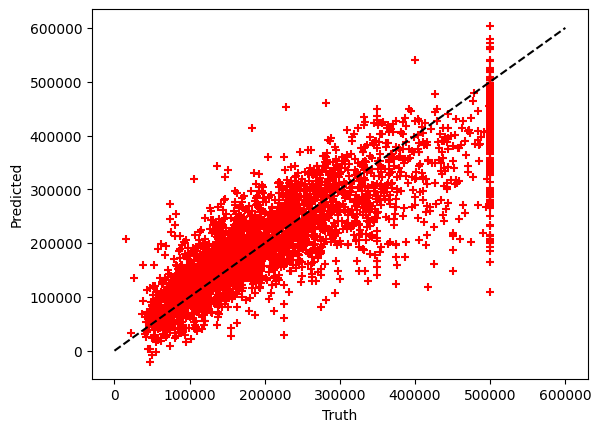

In [94]:
# Unscale the y variable
pred_validation_raw = scaler_y.inverse_transform(pred_validation.detach())
y_validation_raw = scaler_y.inverse_transform(y_validation)
# Plot truth v. predicted
plt.scatter(y_validation_raw, pred_validation_raw, color = 'red', marker = '+')
plt.plot([0., 6E5], [0., 6E5], color="black", linestyle="dashed")
plt.xlabel("Truth")
plt.ylabel("Predicted")
# Check rmse
rmse = np.sqrt(np.mean((pred_validation_raw - y_validation_raw)**2))
rmse

# This is worse than the regressions on Tuesday, but we have only run one iteration

## Train over multiple epochs

Now you have gone through one full iteration of the data, train over multiple epochs and make sure you go through the validation dataset each epoch. Keep track of the training and validation losses averaged over each epoch separately and plot these.

In [122]:
len(dataloader), len(dataloader_validation), len(dataset_validation)/64

(213, 54, 53.125)

In [133]:
training_losses = []
validation_losses = []
num_epochs = 100


for epoch in range(num_epochs):
    # Set up training
    my_network.train()
    training_loss = 0

    # TRAINING LOOP
    # This will look the similar our previous single iteration
    for X_batch, y_batch in dataloader:
      optimiser.zero_grad()
      pred_batch = my_network(X_batch)
      loss = loss_function(pred_batch, y_batch)
      loss.backward()

      # Update optimiser
      optimiser.step()

      # add loss to training loss
      training_loss += loss.item()


    # Sum the training loss at each iteration and store the mean training loss at the end of the epoch
    training_loss = training_loss/len(dataloader)
    training_losses.append(training_loss)

    # Set up validation
    my_network.eval()
    validation_loss = 0

    # VALIDATION LOOP
    # This will look similar to your training loop, but remember you do not need to do the optimise step
    for X_batch, y_batch in dataloader_validation:
      pred_batch = my_network(X_batch)
      loss = loss_function(pred_batch, y_batch)
      validation_loss += loss.item()


    # Add MSE losses to our list for plotting
    validation_loss = validation_loss/len(dataloader_validation)
    validation_losses.append(validation_loss)

    # After every 10 epochs print mean losses
    if epoch%10 ==0:
        print(f"After epoch {epoch}: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")

print(f"At end of training: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")






After epoch 0: Training loss=0.19, validation loss=0.22
After epoch 10: Training loss=0.19, validation loss=0.24
After epoch 20: Training loss=0.19, validation loss=0.23
After epoch 30: Training loss=0.19, validation loss=0.24
After epoch 40: Training loss=0.19, validation loss=0.23
After epoch 50: Training loss=0.19, validation loss=0.22
After epoch 60: Training loss=0.19, validation loss=0.24
After epoch 70: Training loss=0.19, validation loss=0.24
After epoch 80: Training loss=0.19, validation loss=0.24
After epoch 90: Training loss=0.19, validation loss=0.23
At end of training: Training loss=0.19, validation loss=0.23


Check the training and validation loss curves. How do they differ?

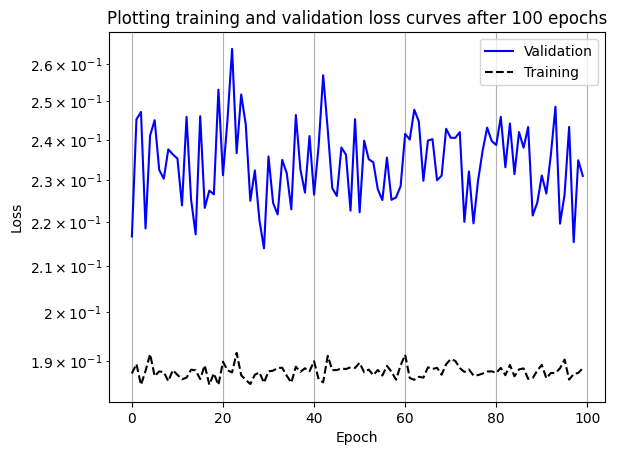

In [135]:
# Plotting training and validation loss curves
fig, ax = plt.subplots(1,1)
plt.plot(validation_losses, color = 'blue', linestyle = '-', label = 'Validation')
plt.plot(training_losses, color = 'black', linestyle = '--', label = 'Training')
ax.set_yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout
plt.legend()
plt.title('Plotting training and validation loss curves after 100 epochs')
plt.show()


np.float64(58364.049196423475)

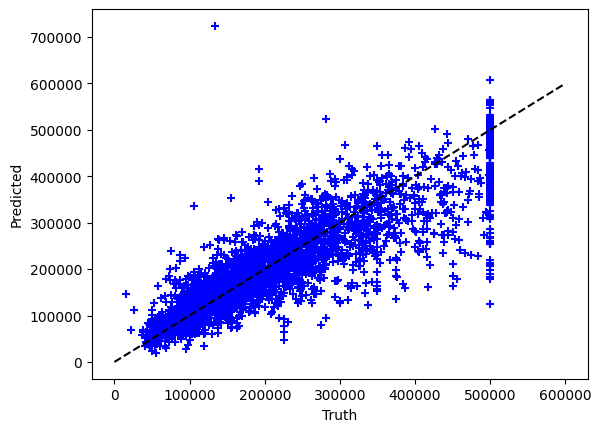

In [125]:
pred_validation = my_network(X_validation)
# Unscale the y variable
pred_validation_raw = scaler_y.inverse_transform(pred_validation.detach())
y_validation_raw = scaler_y.inverse_transform(y_validation)
# Plot truth v. predicted
plt.scatter(y_validation_raw, pred_validation_raw, color = 'blue', marker = '+')
plt.plot([0., 6E5], [0., 6E5], color="black", linestyle="dashed")
plt.xlabel("Truth")
plt.ylabel("Predicted")
# Check rmse
rmse = np.sqrt(np.mean((pred_validation_raw - y_validation_raw)**2))
rmse

## Overfitting
Keep training your network and look for signs of overfitting.

In [126]:
training_losses = []
validation_losses = []
num_epochs = 500


for epoch in range(num_epochs):
    # Set up training
    my_network.train()
    training_loss = 0

    # TRAINING LOOP
    # This will look the similar our previous single iteration
    for X_batch, y_batch in dataloader:
      optimiser.zero_grad()
      pred_batch = my_network(X_batch)
      loss = loss_function(pred_batch, y_batch)
      loss.backward()

      # Update optimiser
      optimiser.step()

      # add loss to training loss
      training_loss += loss.item()


    # Sum the training loss at each iteration and store the mean training loss at the end of the epoch
    training_loss = training_loss/ len(dataloader)
    training_losses.append(training_loss)


    # Set up validation
    my_network.eval()
    validation_loss = 0

    # VALIDATION LOOP
    # This will look similar to your training loop, but remember you do not need to do the optimise step
    for X_batch, y_batch in dataloader:
      pred_batch = my_network(X_batch)
      loss = loss_function(pred_batch, y_batch)
      validation_loss += loss.item()


    # Add MSE losses to our list for plotting
    validation_loss = validation_loss/len(dataloader_validation)
    validation_losses.append(validation_loss)

    # After every 10 epochs print mean losses
    if epoch%10 ==0:
        print(f"After epoch {epoch}: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")

print(f"At end of training: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")






After epoch 0: Training loss=0.19, validation loss=0.76
After epoch 10: Training loss=0.19, validation loss=0.75
After epoch 20: Training loss=0.19, validation loss=0.74
After epoch 30: Training loss=0.19, validation loss=0.73
After epoch 40: Training loss=0.19, validation loss=0.75
After epoch 50: Training loss=0.19, validation loss=0.72
After epoch 60: Training loss=0.19, validation loss=0.71
After epoch 70: Training loss=0.19, validation loss=0.74
After epoch 80: Training loss=0.19, validation loss=0.75
After epoch 90: Training loss=0.19, validation loss=0.72
After epoch 100: Training loss=0.19, validation loss=0.72
After epoch 110: Training loss=0.19, validation loss=0.74
After epoch 120: Training loss=0.19, validation loss=0.73
After epoch 130: Training loss=0.19, validation loss=0.74
After epoch 140: Training loss=0.19, validation loss=0.74
After epoch 150: Training loss=0.19, validation loss=0.74
After epoch 160: Training loss=0.19, validation loss=0.71
After epoch 170: Training

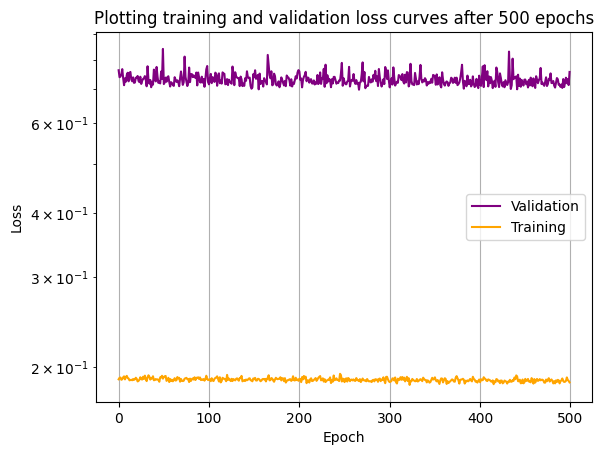

In [131]:
fig, ax = plt.subplots(1,1)
plt.plot(validation_losses, color = 'purple', linestyle = '-', label = 'Validation')
plt.plot(training_losses, color = 'orange', linestyle = '-', label = 'Training')
ax.set_yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout
plt.legend()
plt.title('Plotting training and validation loss curves after 500 epochs')
plt.show()


## Bonus: Exploring different choices
Play around with different versions of the network. For example, try:
* More or fewer layers.
* More of fewer hidden nodes.
* Different choice of [activation functions](https://pytorch.org/docs/main/nn.html#non-linear-activations-weighted-sum-nonlinearity)
* Different choice of [loss functions](https://pytorch.org/docs/main/nn.html#loss-functions)
* Different choice of [optimiser](https://pytorch.org/docs/main/optim.html#algorithms)

Selecting these choices for your problem is an optimisation problem in itself. This is often called hyperparameter selection. There is no best approach - usually people would manually search through some different options until we have the best results. Finding quicker methods for "hyperparameter optimisation" is a research field in itself!



### More layers
Add one layer with 32 hidden nodes and see if it you get a better performance on the validation dataset.

## Bonus: Other network parameters
Explore the following options:
* add BatchNorm
* replace the ReLU activation function with the Sigmoid activation function
* remove a hidden layer
* try a different optimisation method

## Testing
Select your best network and apply it to the test data and calculate the RMSE. Don't forget your outputs are scaled.

In [ ]:
# Open test data
testing = pd.read_csv("sample_data/california_housing_test.csv")
testing.head()

## Compare to Linear Regression
Compare your code the linear regression results you got on Tuesday. Note you will need to re-run your linear regression on this new test dataset. You may also want to re-train on this larger training dataset for a fair comparison.
